# Day 2: Hierarchical Clustering for Trading

## 🎯 Learning Objectives
- Understand hierarchical clustering
- Build dendrograms for asset relationships
- Apply to portfolio construction

---

## 📚 Theory: Hierarchical Clustering

### Types
- **Agglomerative**: Bottom-up (start with individual points)
- **Divisive**: Top-down (start with one cluster)

### Linkage Methods
| Method | Distance Between Clusters |
|--------|-------------------------|
| Single | Min distance |
| Complete | Max distance |
| Average | Mean distance |
| Ward | Minimize variance |

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252

# Download multiple assets
tickers = ['SPY', 'QQQ', 'IWM', 'TLT', 'GLD', 'XLF', 'XLE', 'XLK', 'XLV', 'XLI']
end_date = datetime.now()
start_date = end_date - timedelta(days=3*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 751 days, 10 assets


In [2]:
# Calculate correlation and distance matrices
corr_matrix = returns.corr()
# Convert correlation to distance: distance = sqrt(2*(1-correlation))
dist_matrix = np.sqrt(2 * (1 - corr_matrix))

print("\n📊 Correlation Matrix:")
print(corr_matrix.round(2))


📊 Correlation Matrix:
Ticker   GLD   IWM   QQQ   SPY   TLT   XLE   XLF   XLI   XLK   XLV
Ticker                                                            
GLD     1.00  0.09  0.06  0.07  0.20  0.08 -0.02  0.05  0.07  0.09
IWM     0.09  1.00  0.70  0.80  0.13  0.52  0.77  0.85  0.65  0.51
QQQ     0.06  0.70  1.00  0.95  0.08  0.31  0.60  0.71  0.97  0.39
SPY     0.07  0.80  0.95  1.00  0.10  0.48  0.77  0.85  0.91  0.56
TLT     0.20  0.13  0.08  0.10  1.00 -0.07  0.03  0.06  0.04  0.18
XLE     0.08  0.52  0.31  0.48 -0.07  1.00  0.55  0.55  0.30  0.31
XLF    -0.02  0.77  0.60  0.77  0.03  0.55  1.00  0.81  0.53  0.55
XLI     0.05  0.85  0.71  0.85  0.06  0.55  0.81  1.00  0.68  0.55
XLK     0.07  0.65  0.97  0.91  0.04  0.30  0.53  0.68  1.00  0.34
XLV     0.09  0.51  0.39  0.56  0.18  0.31  0.55  0.55  0.34  1.00


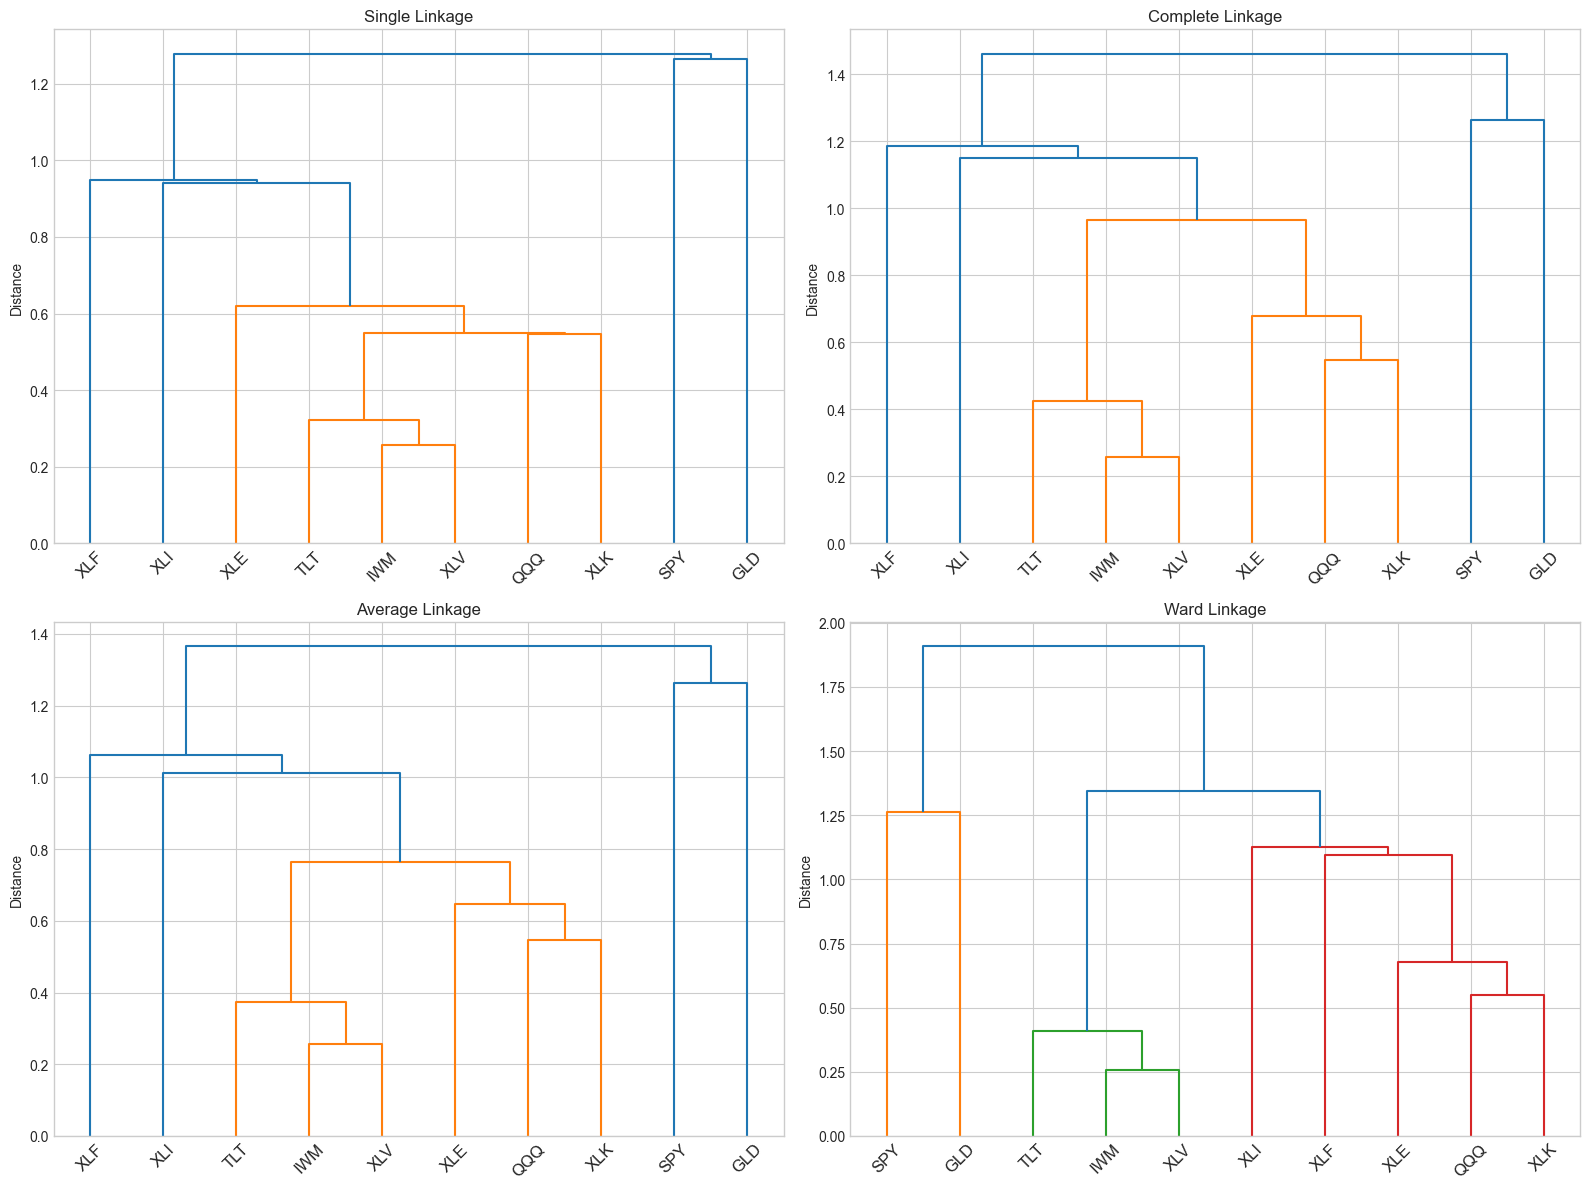

In [3]:
# Hierarchical clustering using different linkage methods
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

linkage_methods = ['single', 'complete', 'average', 'ward']

for ax, method in zip(axes.flatten(), linkage_methods):
    # Use condensed distance matrix
    dist_condensed = squareform(dist_matrix)
    Z = linkage(dist_condensed, method=method)
    
    dendrogram(Z, labels=tickers, ax=ax, leaf_rotation=45)
    ax.set_title(f'{method.capitalize()} Linkage')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()

In [4]:
# Cut dendrogram to form clusters
Z = linkage(squareform(dist_matrix), method='ward')
n_clusters = 3
clusters = fcluster(Z, n_clusters, criterion='maxclust')

# Assign clusters
cluster_df = pd.DataFrame({'Ticker': tickers, 'Cluster': clusters})

print("\n" + "="*60)
print("ASSET CLUSTERS")
print("="*60)
for c in range(1, n_clusters + 1):
    assets = cluster_df[cluster_df['Cluster'] == c]['Ticker'].tolist()
    print(f"\nCluster {c}: {', '.join(assets)}")


ASSET CLUSTERS

Cluster 1: SPY, GLD

Cluster 2: IWM, TLT, XLV

Cluster 3: QQQ, XLF, XLE, XLK, XLI


In [5]:
# HRP-inspired portfolio: equal weight within clusters, then equal weight across clusters
cluster_weights = {}
for c in range(1, n_clusters + 1):
    assets = cluster_df[cluster_df['Cluster'] == c]['Ticker'].tolist()
    weight_per_asset = (1 / n_clusters) / len(assets)
    for asset in assets:
        cluster_weights[asset] = weight_per_asset

weights = pd.Series(cluster_weights)
print("\n📊 Hierarchical Risk Parity Weights:")
print(weights.round(3))


📊 Hierarchical Risk Parity Weights:
SPY    0.167
GLD    0.167
IWM    0.111
TLT    0.111
XLV    0.111
QQQ    0.067
XLF    0.067
XLE    0.067
XLK    0.067
XLI    0.067
dtype: float64


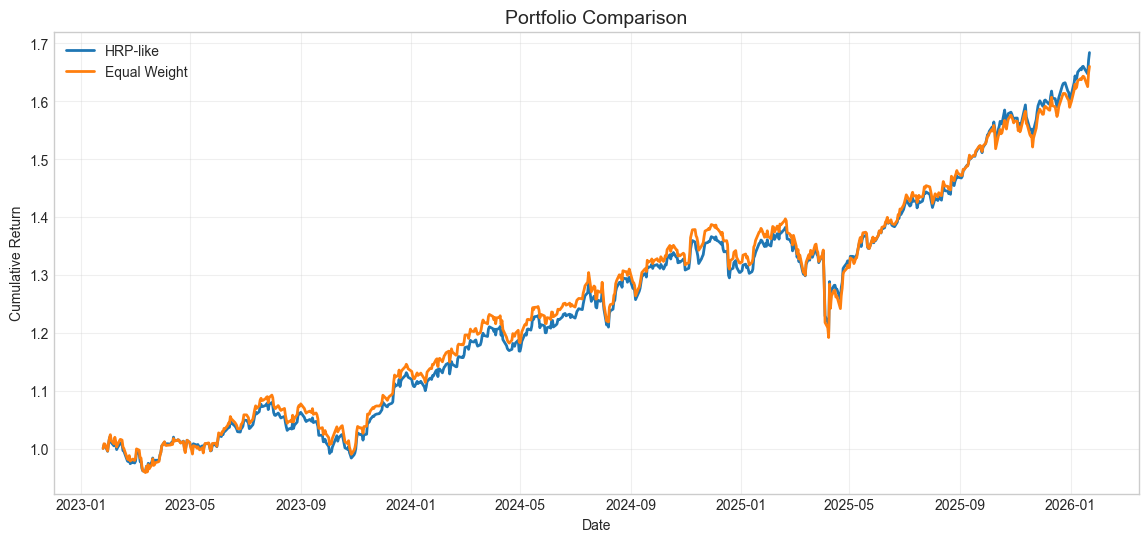

In [6]:
# Compare portfolios
# Equal weight
equal_weights = pd.Series({t: 1/len(tickers) for t in tickers})

# Portfolio returns
hrp_returns = (returns * weights).sum(axis=1)
equal_returns = (returns * equal_weights).sum(axis=1)

# Cumulative
hrp_cum = (1 + hrp_returns).cumprod()
equal_cum = (1 + equal_returns).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(hrp_cum.index, hrp_cum.values, label='HRP-like', linewidth=2)
plt.plot(equal_cum.index, equal_cum.values, label='Equal Weight', linewidth=2)
plt.title('Portfolio Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - 0.05) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("PORTFOLIO PERFORMANCE")
print("="*60)

hrp_total, hrp_sharpe, hrp_mdd = calc_metrics(hrp_returns, hrp_cum)
eq_total, eq_sharpe, eq_mdd = calc_metrics(equal_returns, equal_cum)

print(f"\n{'Portfolio':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)
print(f"{'HRP-like':<15} {hrp_total:>12.2%} {hrp_sharpe:>10.2f} {hrp_mdd:>10.2%}")
print(f"{'Equal Weight':<15} {eq_total:>12.2%} {eq_sharpe:>10.2f} {eq_mdd:>10.2%}")


PORTFOLIO PERFORMANCE

Portfolio          Total Ret     Sharpe     Max DD
--------------------------------------------------
HRP-like              68.41%       1.13    -13.00%
Equal Weight          66.02%       1.02    -14.65%


In [8]:
# Current allocation recommendation
print("\n" + "="*60)
print("📊 CURRENT PORTFOLIO ALLOCATION")
print("="*60)
print(f"\nDate: {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"\nRecommended Weights (HRP-like):")
for c in range(1, n_clusters + 1):
    assets = cluster_df[cluster_df['Cluster'] == c]['Ticker'].tolist()
    print(f"\nCluster {c}:")
    for asset in assets:
        print(f"  {asset}: {weights[asset]:.1%}")


📊 CURRENT PORTFOLIO ALLOCATION

Date: 2026-01-22

Recommended Weights (HRP-like):

Cluster 1:
  SPY: 16.7%
  GLD: 16.7%

Cluster 2:
  IWM: 11.1%
  TLT: 11.1%
  XLV: 11.1%

Cluster 3:
  QQQ: 6.7%
  XLF: 6.7%
  XLE: 6.7%
  XLK: 6.7%
  XLI: 6.7%


---

## 🏢 Real-World Applications

| Company | Hierarchical Clustering Use |
|---------|---------------------------|
| Marcos López de Prado | HRP portfolio construction |
| Asset Managers | Sector/factor grouping |
| Risk Teams | Correlation regime analysis |

---
## 📅 Tomorrow: PCA & Factor Analysis